<a href="https://colab.research.google.com/github/tackulus/229351/blob/main/610510531_LAB04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ปฏิบัติการครั้งที่ 4 กระบวนวิชา 229351 Statistical Learning for Data Science

คำชี้แจง

1. ให้เริ่มทำปฏิบัติการจาก colab notebook ที่กำหนดให้ จากนั้นบันทึกเป็นไฟล์ *.ipynb (File -> Download .ipynb)

#Task 1

# Empirical risk for virus testing

ในปัญหานี้เราจะทำการศึกษาการสร้างวิธีในการจำแนกคนที่เป็นโรคไวรัสจากการทดสอบชนิดหนึ่ง 

กำหนดให้ $R$ (reality) เป็นเหตุการณ์ที่คน $N$ คนเป็นหรือไม่เป็นพาหะนำโรคชนิดนี้

`reality = [r1,r2,...,rN]`

โดยที่ผลจากการทดสอบจะบอกถึงโอกาส (probability) ที่คนๆหนึ่งเป็นพาหะของโรคนี้

`p = [p1,p2,...,pN]`

โดยที่เราจะเป็นคนกำหนดค่า threshold $\alpha$ ที่บอกว่า

* ถ้า `pi` $>\alpha$ แสดงว่าคนที่ `i` **เป็น**พาหะของโรคนี้
* ถ้า `pi` $\leq\alpha$ แสดงว่าคนที่ `i` **ไม่เป็น**พาหะของโรคนี้

กำหนดให้ $D$ (decision) เป็นการตัดสินใจที่ตามมา

`decisions = [d1,d2,...,dN]`

สมมติว่าเรากำหนดให้ความเสียหายจาก **false negative** (ความจริงแล้วเป็นพาหะแต่ผลการทดสอบบอกว่าไม่เป็น) มีค่าเป็น $k$ เท่าของความเสียหายจาก **false positive** (ความจริงแล้วไม่เป็นพาหะแต่ผลการทดสอบบอกว่าเป็น). loss function ที่ได้คือ

$$\begin{cases} \mathcal{l}(di=1,ri=0) = 1\\
\mathcal{l}(di=0,ri=1) = k\\
\mathcal{l}(di=0,ri=0)=\mathcal{l}(di=1,ri=1) = 0\end{cases}$$

นั่นคือ เราสามารถคำนวณ $R$ ได้ด้วยการบวก loss ของการทดสอบที่ผิดพลาดทั้งหมด แล้วหารด้วยจำนวณการทดสอบทั้งหมด

สร้างข้อมูลจำลองด้วยโค้ดข้างล่างนี้

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

# Note: don't make any changes to this function
def generate_ground_truth(N, prevalence):
    """ Creates simulated p corresponding to N subjects at a 
    specified disease prevalence level"""
    rs = np.random.RandomState(1)
    reality = rs.binomial(1, prevalence, N)
    p = 1 - norm.cdf(rs.randn(N) + reality)
    return(p, reality)

# Generate p: Do not modify
N = 10000
prevalence = 0.05
p, reality = generate_ground_truth(N, prevalence)


ฟังก์ชัน `alpha_threshold_decisions` ใช้ในการตัดสินใจว่าแต่ละคนเป็นหรือไม่เป็นพาหะ (`decisions`)

In [ ]:
# Note: don't make any changes to this function, this is exatly the naive thresholding you completed in Lab 1
def alpha_threshold_decisions(p, alpha):
    """
    Returns decisions on p using naive thresholding.
    
    Inputs:
        p: array of p
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p, where `decisions[i]` is 1
        if `p[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    decisions = p <= alpha
    return decisions

ฟังก์ชัน `report_results` ใช้ในการคำนวณว่าการตัดสินใจถูกหรือผิดอย่างไรบ้าง

* TP (true positive): `ri`=1,`di`=1 
* TN (true negative): `ri`=0,`di`=0 
* FP (false positive): `ri`=0,`di`=1 
* FN (false negative): `ri`=1,`di`=0 

In [ ]:
# Note: don't make any changes to this function, this is the report_results function you completed in Lab 1
def report_results(decisions, reality):
    """
    Produces a dictionary with counts for the true positives, true negatives,
    false negatives, and false positives from the input `decisions`
    and `reality` arrays.
    
    Inputs:
      decision: array of 0/1 values where 1 indicates that patient has the virus.
      reality: array of 0/1 values where 1 indicates a draw from the alternative.
    
    Outputs: a dictionary of TN, TP, FN, and FP counts.
    """   
    
    TP_count = sum(decisions*reality)
    TN_count = sum((1-decisions)*(1-reality))
    FP_count = sum((decisions)*(1-reality))
    FN_count = sum((1-decisions)*(reality))
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    return results_dictionary

###Exercise 1a: เติมฟังก์ชันเพื่อคำนวณ empirical risk จากค่าจำนวนความถูกต้องและจำนวนความผิดพลาด (TP, FP, TN, FN) ที่บันทึกใน `results_dictionary` โดยที่ `factor_k` คือค่า $k$ ที่ระบุในนิยามของ loss function ข้างบน

In [ ]:
# TODO: fill in
def compute_empirical_risk(results_dictionary, factor_k):
    """ Function that computes average loss for a given confusion matrix and a multiplicaltive
        k_factor that compares the consequences of false nagatives and false positives.
        
        Inputs:
            results_dictionary : a dictionary with the counts of TP, FP, TN and FN
            k_factor : float, quantifies the ratio of the negative consequences of
                       false negatives compared to false positives
                       
        Outputs:
            empirical_risk : float
    """
    
    TP_count = results_dictionary['TP_count']
    FP_count = results_dictionary['FP_count']
    TN_count = results_dictionary['TN_count']
    FN_count = results_dictionary['FN_count']
    
    N = TP_count + TN_count + FP_count + FN_count
    empirical_risk = (FP_count + factor_k * FN_count) / N # TODO: fill in
    return(empirical_risk)

In [ ]:
res_dict = {'TP_count': 100, 'FP_count': 20, 'TN_count':450, 'FN_count':30}
k_factors = [0, 10, 100]
for i, k in enumerate(k_factors):
    empirical_risk = compute_empirical_risk(res_dict, k)
    print(empirical_risk)

#Answers should be: 
# 0.03333333333333333
# 0.5333333333333333
# 5.033333333333333
# 5.033333333333333

0.03333333333333333
0.5333333333333333
5.033333333333333


###Exercise 1b: เติมฟังก์ชันเพื่อคำนวณ empirical risk โดยที่มี argument ดังนี้ 

* `reality` การเป็นพาหะจริง  
* `p` ความน่าจะเป็นที่ได้จากการทดสอบ 
* `alpha` ค่า threshold ในการตัดสินใจว่าแต่ละคนเป็นพาหะหรือไม่
* `factor_k` คือค่า $k$ ที่ระบุในนิยามของ loss function ข้างบน

In [ ]:
# TODO: complete the function
def compute_alpha_empirical_risk(p, reality, alpha, factor_k):
    """ 
    Computes the observed average loss for an alpha level test.
    
    Inputs:
        p: array of floats, p[i] is the probability associated with test subject i.
        reality: array of 0/1s
        alpha: float, threshold for rejecting the null hypothesis
        factor_k: float, quantifies the ratio of the negative consequences of
                  false negatives compared to false positives
                  
    Outputs:
        empirical_risk: float, average observed loss
    """
    decisions = [x <= alpha for x in p]
    FP_count = sum([x & (~y) for x,y in zip(decisions, reality)])
    FN_count = sum([(~x) & y for x,y in zip(decisions, reality)])

    empirical_risk = (FP_count + factor_k * FN_count) / len(reality)
    return empirical_risk

In [ ]:
print('At level alpha=', 0.05 ,' and k=', 0 ,'   the average loss is', \
      compute_alpha_empirical_risk(p, reality,0.05,0))
print('At level alpha=', 0.05 ,' and k=', 10 ,'  the average loss is', \
      compute_alpha_empirical_risk(p, reality,0.05,10))
print('At level alpha=', 0.05 ,' and k=', 100 ,' the average loss is', \
      compute_alpha_empirical_risk(p, reality,0.05,100))

#Answers should be 0.0499, 0.3909, 3.4599

At level alpha= 0.05  and k= 0    the average loss is 0.0499
At level alpha= 0.05  and k= 10   the average loss is 0.3909
At level alpha= 0.05  and k= 100  the average loss is 3.4599


In [ ]:
# Run this as is after completing the `compute_alpha_empirical_risk` function
# Do not modify
def plot_empirical_risk(factor_k):
    N = 10000
    # generate ground truth
    p, reality = generate_ground_truth(N, 0.05)
    # vary alpha from 0 to 1
    alpha_array = np.arange(0,1, 0.05)
    # compute average loss for each alpha
    empirical_risk_array = [compute_alpha_empirical_risk(p, reality, alpha, factor_k) for alpha in alpha_array]
    optimal_alpha = alpha_array[np.argmin(empirical_risk_array)]
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_array, empirical_risk_array, label = 'Average Loss')
    plt.axvline(x=optimal_alpha, ls='--', label = 'Optimal $\\alpha$', c='green')
    plt.xlabel('$\\alpha$ level')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()

In [ ]:
from ipywidgets import interact, interactive

# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_empirical_risk, factor_k=(0, 100, 5))
interactive_plot

interactive(children=(IntSlider(value=50, description='factor_k', step=5), Output()), _dom_classes=('widget-in…

### Exercise 1c: factor_k กับค่า $\alpha$ ที่ดีทีสุด (Optimal $\alpha$) มีความสัมพันธ์กันอย่างไร เพราะเหตุใด

คำตอบ: factor_k แปรผันตรงกับ optimal $\alpha$

        - เมื่อ factor_k มีค่าน้อย แสดงว่าการเกิด False Positive ทำให้เกิดความเสียหายมากกว่า จึงใช้ alpha ค่าน้อยเพื่อโน้มการตัดสินใจให้เป็น negative
        - เมื่อ factor_k มีค่ามาก แสดงว่าการเกิด False Negative ทำให้เกิดความเสียหายมากกว่า จึงใช้ค่า alpha ค่ามากเพื่อโน้มการตัดสินใจให้เป็น positive

#Task 2

###Sample points

In [ ]:
np.random.seed(42)

N = 8
x = 10 ** np.linspace(-2, 0, N)
y = np.random.normal(loc = 10 - 1. / (x + 0.1), scale= 0.5)

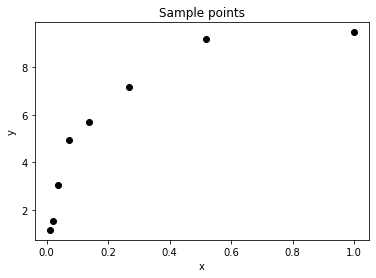

In [ ]:
plt.figure()
plt.scatter(x, y, c='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sample points');

###Polynomial regression

In [ ]:
p = np.polyfit(x, y, 2)


xfit = np.linspace(-0.2, 1.2, 1000)
yfit = np.polyval(p, xfit)

Text(0.5, 1.0, 'd = 2')

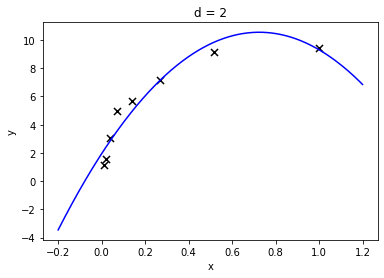

In [ ]:
plt.figure()
plt.scatter(x, y, marker='x', c='k', s=50)
plt.plot(xfit, yfit, '-b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('d = 2')

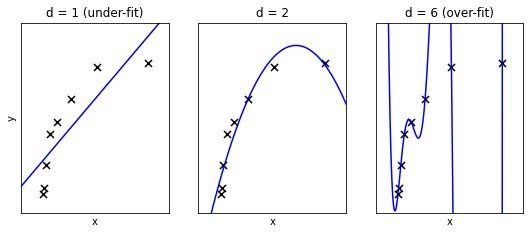

In [ ]:
xfit = np.linspace(-0.2, 1.2, 1000)

titles = ['d = 1 (under-fit)', 'd = 2', 'd = 6 (over-fit)']
degrees = [1, 2, 6]

plt.figure(figsize = (9, 3.5))
for i, d in enumerate(degrees):
    plt.subplot(131 + i, xticks=[], yticks=[])
    plt.scatter(x, y, marker='x', c='k', s=50)

    p = np.polyfit(x, y, d)
    yfit = np.polyval(p, xfit)
    plt.plot(xfit, yfit, '-b')
    
    plt.xlim(-0.2, 1.2)
    plt.ylim(0, 12)
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')

    plt.title(titles[i])

In [ ]:
np.random.seed(42)

Ntrain = 100
Ntest = 100
error = 1.0

np.random.seed(0)
x = np.random.random(Ntrain + Ntest)
y = np.random.normal(loc = 10 - 1. / (x + 0.1), scale= 0.5)

xtrain = x[:Ntrain]
ytrain = y[:Ntrain]

xtest = x[Ntrain:]
ytest = y[Ntrain:]

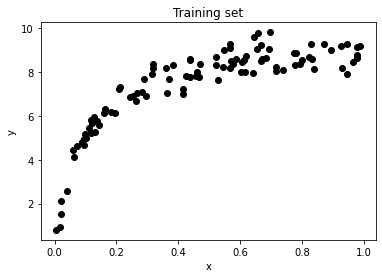

In [ ]:
plt.scatter(xtrain, ytrain, c='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training set');

In [ ]:
def empirical_risk(y, yfit):
    return np.mean((y - yfit) ** 2)

#Exercise 2: 
1. ทำการสร้าง polynomial regression ที่มีค่า degree ตั้งแต่ 1-20 โดยใช้ training set ข้างบน 
2. หลังจากสร้างโมเดลแต่ละตัวเสร็จแล้ว ให้คำนวณค่า empirical risk ของการทำนายบน test set เก็บค่าที่ได้ไว้ใน list ที่ชื่อว่า `empirical_risks` (เพราะฉะนั้น list นี้จะมีสมาชิก 20 ตัว)
3. สร้าง plot โดยให้แกนนอนคือค่า degree ของโมเดลแต่ละตัว และแกนตั้งคือค่า empirical risk ของโมเดลตัวนั้น 
4. ระบุค่า degree ที่มี emprical risk ต่ำที่สุด
ค่า degree ไหนบ้างที่ทำให้โมเดล overfit และค่า degree ไหนบ้างที่ทำให้โมเดล underfit

In [ ]:
%%capture
max_deg = 20

empirical_risks = [0]*max_deg

for i in range(1,max_deg +1):
  #TODO: fill code here
  p = np.polyfit(xtrain, ytrain, i)

  y = np.polyval(p, xtest)
  empirical_risks[i-1] = empirical_risk(ytest, y)

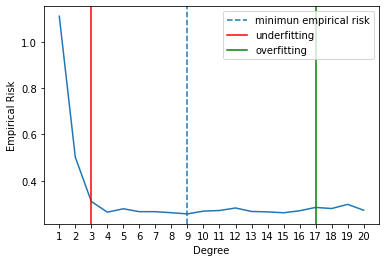

In [ ]:
plt.figure()
plt.plot(np.arange(1, 1+max_deg), empirical_risks)
plt.xticks(np.arange(1, 1+max_deg, 1.0))
plt.xlabel("Degree")
plt.ylabel("Empirical Risk")
plt.axvline(x=1+np.argmin(empirical_risks), ls="--", label="minimun empirical risk")
plt.axvline(x=3, color="red", ls="-", label="underfitting")
plt.axvline(x=17, color="green", ls="-", label="overfitting")
plt.legend()
plt.show()

จากกราฟได้ว่า ค่าต่ำสุดของ empirical risk เกิด ณ degree= 9
และเกิด underfitting สำหรับพหุนามดีกรี $\leq 3$

(จากกราฟไม่มี overfitting ที่เห็นชัด แต่อาจอนุมานได้ว่า เริ่มเกิด overfitting ที่พหุนามดีกรี $\geq 17$